# Лабораторная работа №1

## Часть 1. Выполнил Филенков Алексей Дмитриевич

### Загрузка и изучение первой таблицы

Imports

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [ ]:
df_july = pd.read_excel("database/July.xls",'платные всего',skiprows=(0,1,2,3,4,5))
df_july.columns = ("Place","In Fact","Previous month %","The same month prev year %")
df_july

In [ ]:
areas = df_july['Place'].apply(lambda data: True if 'федеральный округ' in data else False)
areas.iloc[0] = True
areas
# Россия + агрегирующие строки по округам
df_july[areas]

# Все остальные
df_july[~areas]

# Добавим данные о месяце
df_july["month"] = "July"
df_july

Превратим обработку одной таблицы в функцию и соберём данные за 2024 год

In [ ]:
def preprocess_table(df,month):
    areas = df['Place'].apply(lambda data: True if 'федеральный округ' in data else False)
    areas.iloc[0] = True
    areas
    # Россия + агрегирующие строки по округам
    df_districts = df[areas]

    # Все остальные
    df_areas = df[~areas]

    # Добавим данные о месяце
    df_districts["month"] = month
    df_areas["month"] = month
    return df_districts, df_areas

list_of_months = ["April","February","January","July","June","March","May"]
print(f"Count of months: {len(list_of_months)}")

full_df_districts = pd.DataFrame()
full_df_areas = pd.DataFrame()
for month in list_of_months:
    df = pd.read_excel(f"database/{month}.xls",'платные всего',skiprows=(0,1,2,3,4,5))
    df.columns = ("Place","In Fact","Previous month %","The same month prev year %")
    df_districts, df_areas = preprocess_table(df,month)
    
    if full_df_areas.shape:
        full_df_areas = pd.concat([full_df_areas,df_areas],axis=0)
    else:
        full_df_areas = df_areas

    if full_df_districts.shape:
        full_df_districts = pd.concat([full_df_districts,df_districts],axis=0)
    else:
        full_df_districts = df_districts
    

### Узнаем параметры данных за 2024 год
1) Среднее
2) Медиану
3) Среднеквадратичное отклонение

In [ ]:
# Параметры для областей
mean_areas = int(full_df_areas["In Fact"].mean())
median_areas = int(full_df_areas["In Fact"].median())
var_areas = int(full_df_areas["In Fact"].var())
print(f"Areas mean: {mean_areas}, median:{median_areas}, var:{var_areas}")

# Параметры для округов
mean_districts = int(full_df_districts["In Fact"].mean())
median_districts = int(full_df_districts["In Fact"].median())
var_districts = int(full_df_districts["In Fact"].var())
print(f"Districts mean: {mean_districts}, median:{median_districts}, var:{var_districts}")

### Агрегируем по месту (топ 10)

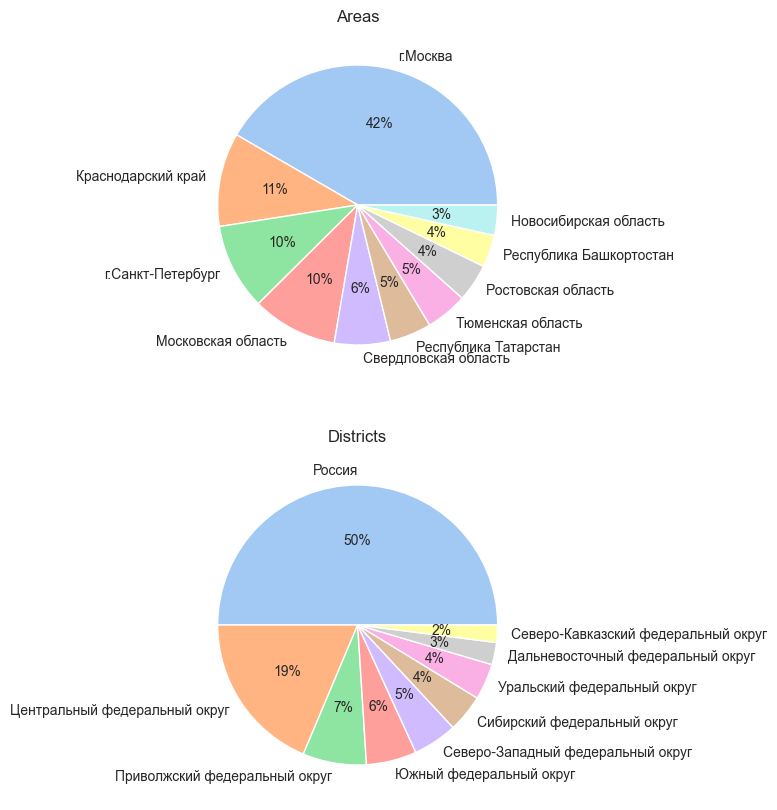

In [111]:
X1 = full_df_areas.drop(columns=['month']).groupby(by="Place").mean()
X1 = X1.sort_values(by="In Fact",ascending=False).head(10)

X2 = full_df_districts.drop(columns=['month']).groupby(by="Place").mean()
X2 = X2.sort_values(by="In Fact",ascending=False).head(10)

# Столбчатая диаграмма
# plt.figure(figsize=(20,5),dpi=200)
# plt.xticks(rotation=45)
# sns.barplot(data=X1, x="Place", y="In Fact")

# Круговая диаграмма
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.title("Areas")
colors = sns.color_palette('pastel')[ 0:10 ]
plt.pie(X1["In Fact"], labels = X1.index, colors = colors, autopct='%.0f%%')

plt.subplot(2, 2, 3)
plt.title("Districts")
colors = sns.color_palette('pastel')[ 0:10 ]
plt.pie(X2["In Fact"], labels = X2.index, colors = colors, autopct='%.0f%%')
plt.show()

Вывод: Видно, что Москва и как следствие Центральный федеральный округ получают наибольшее кол-во средств за платные услуги

Агрегируем данные платных услуг по месяцам

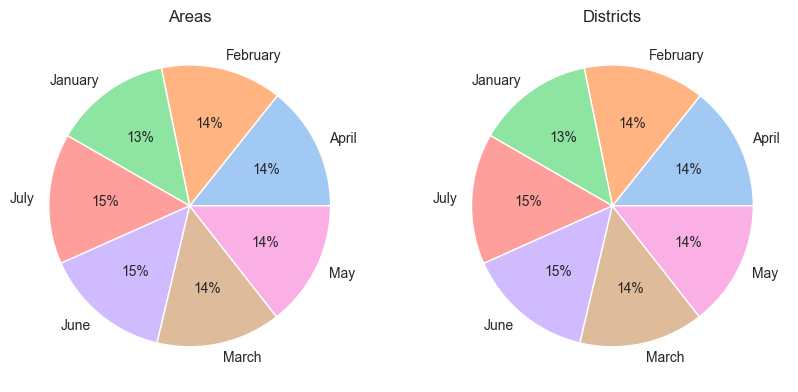

In [113]:
X1 = full_df_areas[["In Fact","Previous month %","The same month prev year %","month"]].groupby(by="month").mean()
X2 = full_df_districts[["In Fact","Previous month %","The same month prev year %","month"]].groupby(by="month").mean()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Areas")
colors = sns.color_palette('pastel')[ 0:10 ]
plt.pie(X1["In Fact"], labels = X1.index, colors = colors, autopct='%.0f%%')

plt.subplot(1, 2, 2)
plt.title("Districts")
colors = sns.color_palette('pastel')[ 0:10 ]
plt.pie(X2["In Fact"], labels = X2.index, colors = colors, autopct='%.0f%%')
plt.show()

Полученный доход распределён равномерно по месяцам

### Посмотрим распределения по месяцам

In [ ]:
for month in list_of_months:
    X1 = full_df_areas[month]